<a href="https://colab.research.google.com/github/AUT-Student/NN-HW2/blob/main/NN_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# Datasets

In [2]:
class Dataset():
  def __init__(self, dataset_type):
    if dataset_type == "LinearSeprable":
      self._create_ls_dataset()
    elif dataset_type == "XOR":
      self._create_xor_dataset()

    self._shuffle_and_split()

  def _create_ls_dataset(self):
    cov = [[1, 0], [0, 1]]

    mean_0 = [0,0]
    mean_1 = [10,10]

    number_data_per_class = 5000    

    data_0 = pd.DataFrame(np.random.multivariate_normal(mean_0, cov, number_data_per_class), columns=["X1", "X2"])
    data_0["Y"] = [-1] * number_data_per_class 

    data_1 = pd.DataFrame(np.random.multivariate_normal(mean_1, cov, number_data_per_class), columns=["X1", "X2"])
    data_1["Y"] = [+1] * number_data_per_class

    self.data = pd.concat([data_0, data_1], ignore_index= True)

  def _create_xor_dataset(self):
    cov = [[1, 0], [0, 1]]

    mean_00 = [0, 0]
    mean_01 = [0, 10] 
    mean_10 = [10, 0] 
    mean_11 = [10, 10] 

    number_data_per_part = 2500

    number_data_per_part = 2500

    data_00 = pd.DataFrame(np.random.multivariate_normal(mean_00, cov, number_data_per_part), columns=["X1", "X2"])
    data_00["Y"] = [-1] * number_data_per_part 

    data_11 = pd.DataFrame(np.random.multivariate_normal(mean_11, cov, number_data_per_part), columns=["X1", "X2"])
    data_11["Y"] = [-1] * number_data_per_part 

    data_01 = pd.DataFrame(np.random.multivariate_normal(mean_01, cov, number_data_per_part), columns=["X1", "X2"])
    data_01["Y"] = [+1] * number_data_per_part 

    data_10 = pd.DataFrame(np.random.multivariate_normal(mean_10, cov, number_data_per_part), columns=["X1", "X2"])
    data_10["Y"] = [+1] * number_data_per_part 

    self.data = pd.concat([data_00, data_01, data_10, data_11], ignore_index= True)


  def _shuffle_and_split(self):
    self.data = self.data.sample(frac=1).reset_index()

    # 70% train, 10% validation, 20% test
    self.train_data = self.data[:7000]
    self.validation_data = self.data[7000:8000]
    self.test_data = self.data[8000:]

  def plot_dataset(self):
    plt.scatter(self.data[self.data["Y"]==-1]["X1"], self.data[self.data["Y"]==-1]["X2"], label="Class -", c="red")
    plt.scatter(self.data[self.data["Y"]==+1]["X1"], self.data[self.data["Y"]==+1]["X2"], label="Class +", c="green")

    plt.legend()
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.title("Dataset Overview")
    plt.show()

  def X_train(self):
    return self.train_data[["X1", "X2"]].values

  def Y_train(self):
    return self.train_data["Y"].values

  def X_validation(self):
    return self.validation_data[["X1", "X2"]].values

  def Y_validation(self):
    return self.validation_data["Y"].values

  def X_test(self):
    return self.test_data[["X1", "X2"]].values

  def Y_test(self):
    return self.test_data["Y"].values

  def train(self):
    return self.train_data

  def validation(self):
    return self.validation_data

  def test(self):
    return self.test_data

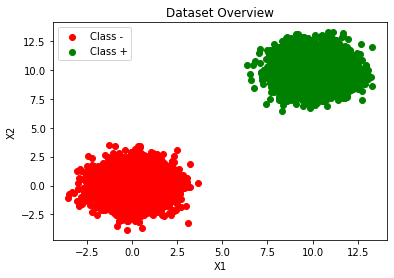

In [3]:
ls_dataset = Dataset("LinearSeprable")
ls_dataset.plot_dataset()

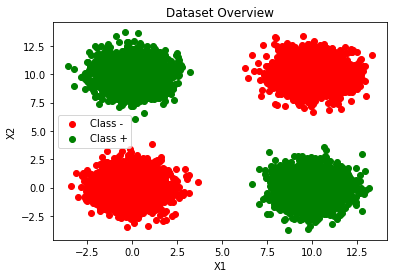

In [4]:
xor_dataset = Dataset("XOR")
xor_dataset.plot_dataset()

# Activation Functions

In [5]:
class ActivationFunctions():
  @staticmethod
  def bipolar_sigmoid(x):
    return (1 - math.exp(-x)) / (1 + math.exp(-x))

  @staticmethod
  def identity(x):
    return x

  @staticmethod
  def sign(x):
    if x>= 0:
      return +1
    else:
      return -1

  @staticmethod
  def generate_step(t):
    def step(x):
      if x >= t:
        return +1
      else:
        return -1
    
    return step

  @staticmethod
  def tanh(x):
    return np.tanh(x)

# Perceptron

In [11]:
class Perceptron():
  def __init__(self, alpha, activation_function, degree=1):
    self.alpha = alpha
    self.activation_function = activation_function
    self.error_values = []
    self.degree = degree

    if self.degree == 1:
      self.w = np.random.uniform(low=-1, high=+1, size=(3,))
    elif self.degree == 2:
      self.w = np.random.uniform(low=-1, high=+1, size=(5,))
   
  def complete_X(self, X):
    if self.degree == 1:
      return np.concatenate(([1], X))
    elif self.degree == 2:
      return np.array([1, X[0], X[1], X[0]**2, X[1]**2])

  def predict(self, X):
    I = self.w @ self.complete_X(X)
    y = self.activation_function(I)
    return y

  def error(self, X, t):
    sum = 0
    for i in range(len(t)):
      sum += np.abs(self.predict(X[i]) - t[i])
    return sum/(2*len(t))

  def accuracy(self, X, t):
    number_true = 0
    for i in range(len(t)):
      if self.predict(X[i])==t[i]:
        number_true += 1
    
    return number_true/len(t)

  def train_sample(self, X, t):
    y = self.predict(X)
    self.w = self.w + self.alpha * (t-y) * self.complete_X(X)

  def train(self, dataset, epochs):
    self.X_train = dataset.X_train()
    self.y_train = dataset.Y_train()
    self.X_validation = dataset.X_validation()
    self.y_validation = dataset.Y_validation()

    for epoch in range(epochs):
      for i in range(len(self.X_train)):
        self.train_sample(self.X_train[i], self.y_train[i])

        if (i+1)%1000 == 0:
          self.error_values.append(
              {"i": epoch*len(self.X_train) + i,
               "train_error": self.error(self.X_train, self.y_train),
               "validation_error": self.error(self.X_validation, self.y_validation),
               "train_accuracy": self.accuracy(self.X_train, self.y_train),
               "validation_accuracy": self.accuracy(self.X_validation, self.y_validation)
               })
    
  def show_error_values(self):
    i_list = []
    train_error_list = []
    validation_error_list = []
    train_accuracy_list = []
    validation_accuracy_list = []

    for item in self.error_values:
      i_list.append(item["i"])
      train_error_list.append(item["train_error"])
      validation_error_list.append(item["validation_error"])
      train_accuracy_list.append(item["train_accuracy"])
      validation_accuracy_list.append(item["validation_accuracy"])

    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    ax1.scatter(i_list, train_error_list, c="blue", label="Train Error", alpha=0.5)
    ax1.plot(i_list, train_error_list, c="blue", alpha=0.5)
    ax1.scatter(i_list, validation_error_list, c="red", label="Validation Error", alpha=0.5)
    ax1.plot(i_list, validation_error_list, c="red", alpha=0.5)

    ax1.legend()
    ax1.set_xlabel("Number Trained Data")
    ax1.set_ylabel("Error")
    ax1.set_title(f"Error Changes in the Perceptron\nDegree = {self.degree} Learning Rate = {self.alpha}")

    ax2.scatter(i_list, train_accuracy_list, c="blue", label="Train Accuracy", alpha=0.5)
    ax2.plot(i_list, train_accuracy_list, c="blue", alpha=0.5)
    ax2.scatter(i_list, validation_accuracy_list, c="red", label="Validation Accuracy", alpha=0.5)
    ax2.plot(i_list, validation_accuracy_list, c="red", alpha=0.5)

    ax2.legend()
    ax2.set_xlabel("Number Trained Data")
    ax2.set_ylabel("Accuracy")
    ax2.set_title(f"Accuracy Changes in the Perceptron\nDegree = {self.degree} Learning Rate = {self.alpha}")
    
    fig.set_size_inches(12, 5)
    plt.show()

    print(f"Final Train Accuracy = {self.accuracy(self.X_train, self.y_train)}")
    print(f"Final Validation Accuracy = {self.accuracy(self.X_validation, self.y_validation)}")


  def show_decision_boundry(self):
    plt.scatter(self.X_train[np.where(self.y_train==-1)[0]][:, 0], self.X_train[np.where(self.y_train==-1)[0]][:, 1], label="Class -", c="red")
    plt.scatter(self.X_train[np.where(self.y_train==+1)[0]][:, 0], self.X_train[np.where(self.y_train==+1)[0]][:, 1], label="Class +", c="green")

    boundry_points_x1 = []
    boundry_points_x2 = []

    for x1 in np.linspace(-4, 14, 200):
      for x2 in np.linspace(-4, 14, 200):

        if self.predict([x1, x2])!=self.predict([x1+0.3, x2+0.3]):
          boundry_points_x1.append(x1)
          boundry_points_x2.append(x2)
       
    plt.scatter(boundry_points_x1, boundry_points_x2, label="Decision Boundry", c="blue", alpha=0.25)

    plt.legend()
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.title("Perceptron Decision Boundary")
    plt.show()      

# Adaline

In [17]:
class Adaline():
  def __init__(self, alpha, activation_function, degree=1):
    self.alpha = alpha
    self.activation_function = activation_function
    self.error_values = []
    self.degree = degree

    if self.degree == 1:
      self.w = np.random.uniform(low=-1, high=+1, size=(3,))
    elif self.degree == 2:
      self.w = np.random.uniform(low=-1, high=+1, size=(6,))

  def error(self, X, t):
    sum = 0
    for i in range(len(t)):
      sum += (self.linear_output(X[i]) - t[i])**2
    return sum/(len(t))

  def accuracy(self, X, t):
    number_true = 0
    for i in range(len(t)):
      if self.predict(X[i])==t[i]:
        number_true += 1
    
    return number_true/len(t)

  def complete_X(self, X):
    if self.degree == 1:
      return np.concatenate(([1], X))
    elif self.degree == 2:
      return np.array([1, X[0], X[1], X[0]**2, X[1]**2, X[0]*X[1]])

  def linear_output(self, X):
    I = self.w @ self.complete_X(X)
    y = self.activation_function(I)
    return y

  def bipolar_output(self, X):
    return np.sign(self.linear_output(X))

  def predict(self, X):
    return self.bipolar_output(X)

  def train_sample(self, X, t):
    y = self.linear_output(X)
    self.w = self.w + self.alpha * (t-y) * self.complete_X(X)


  def train(self, dataset, epochs):
    self.X_train = dataset.X_train()
    self.y_train = dataset.Y_train()
    self.X_validation = dataset.X_validation()
    self.y_validation = dataset.Y_validation()

    for epoch in range(epochs):
      for i in range(len(self.X_train)):
        self.train_sample(self.X_train[i], self.y_train[i])

        if (i+1)%1000 == 0:
          self.error_values.append(
              {"i": epoch*len(self.X_train) + i,
               "train_error": self.error(self.X_train, self.y_train),
               "validation_error": self.error(self.X_validation, self.y_validation),
               "train_accuracy": self.accuracy(self.X_train, self.y_train),
               "validation_accuracy": self.accuracy(self.X_validation, self.y_validation)
               })
    
  def show_error_values(self):
    i_list = []
    train_error_list = []
    validation_error_list = []
    train_accuracy_list = []
    validation_accuracy_list = []

    for item in self.error_values:
      i_list.append(item["i"])
      train_error_list.append(item["train_error"])
      validation_error_list.append(item["validation_error"])
      train_accuracy_list.append(item["train_accuracy"])
      validation_accuracy_list.append(item["validation_accuracy"])

    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    ax1.scatter(i_list, train_error_list, c="blue", label="Train Error", alpha=0.5)
    ax1.plot(i_list, train_error_list, c="blue", alpha=0.5)
    ax1.scatter(i_list, validation_error_list, c="red", label="Validation Error", alpha=0.5)
    ax1.plot(i_list, validation_error_list, c="red", alpha=0.5)

    ax1.legend()
    ax1.set_xlabel("Number Trained Data")
    ax1.set_ylabel("Error")
    ax1.set_title(f"Error Changes in the Perceptron\nDegree = {self.degree} Learning Rate = {self.alpha}")

    ax2.scatter(i_list, train_accuracy_list, c="blue", label="Train Accuracy", alpha=0.5)
    ax2.plot(i_list, train_accuracy_list, c="blue", alpha=0.5)
    ax2.scatter(i_list, validation_accuracy_list, c="red", label="Validation Accuracy", alpha=0.5)
    ax2.plot(i_list, validation_accuracy_list, c="red", alpha=0.5)

    ax2.legend()
    ax2.set_xlabel("Number Trained Data")
    ax2.set_ylabel("Accuracy")
    ax2.set_title(f"Accuracy Changes in the Perceptron\nDegree = {self.degree} Learning Rate = {self.alpha}")
    
    fig.set_size_inches(12, 5)
    plt.show()

    print(f"Final Train Accuracy = {self.accuracy(self.X_train, self.y_train)}")
    print(f"Final Validation Accuracy = {self.accuracy(self.X_validation, self.y_validation)}")

  def show_decision_boundry(self):
    plt.scatter(self.X_train[np.where(self.y_train==-1)[0]][:, 0], self.X_train[np.where(self.y_train==-1)[0]][:, 1], label="Class -", c="red")
    plt.scatter(self.X_train[np.where(self.y_train==+1)[0]][:, 0], self.X_train[np.where(self.y_train==+1)[0]][:, 1], label="Class +", c="green")

    boundry_points_x1 = []
    boundry_points_x2 = []

    for x1 in np.linspace(-4, 14, 200):
      for x2 in np.linspace(-4, 14, 200):

        if self.predict([x1, x2])!=self.predict([x1+0.3, x2+0.3]):
          boundry_points_x1.append(x1)
          boundry_points_x2.append(x2)
       
    plt.scatter(boundry_points_x1, boundry_points_x2, label="Decision Boundry", c="blue", alpha=0.25)

    plt.legend()
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.title("Adaline Decision Boundary")
    plt.show()      

# Expriments Part 3

## Perceptron

### Learning Rate


alpha = 1e-05


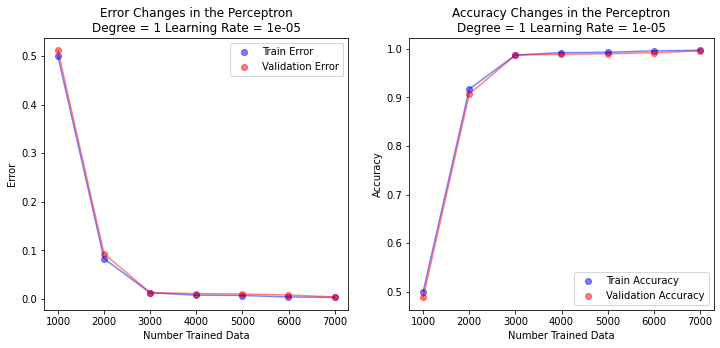

Final Train Accuracy = 0.997
Final Validation Accuracy = 0.996

alpha = 0.01


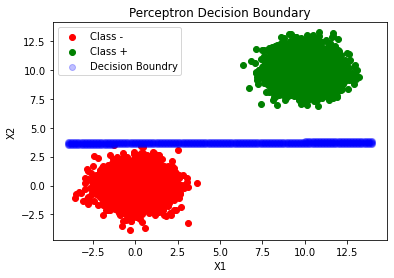

Final Train Accuracy = 1.0
Final Validation Accuracy = 1.0

alpha = 0.1


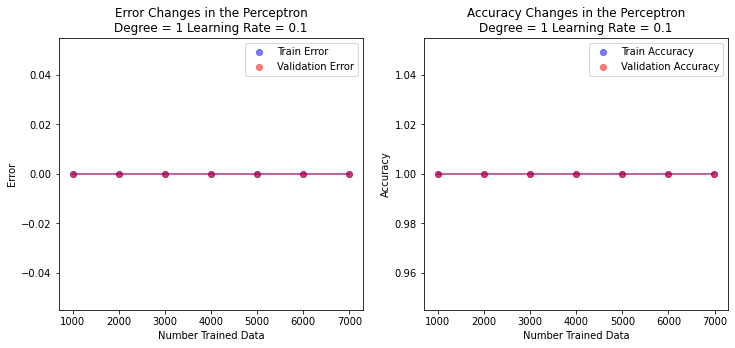

Final Train Accuracy = 1.0
Final Validation Accuracy = 1.0

alpha = 1


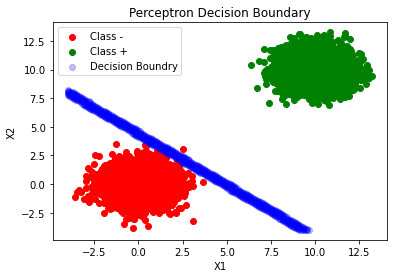

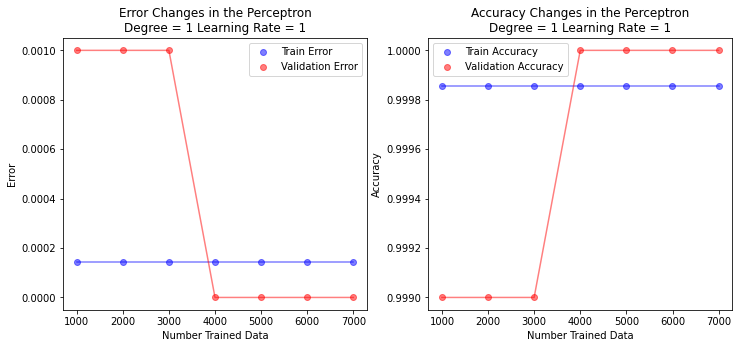

Final Train Accuracy = 0.9998571428571429
Final Validation Accuracy = 1.0

alpha = 100


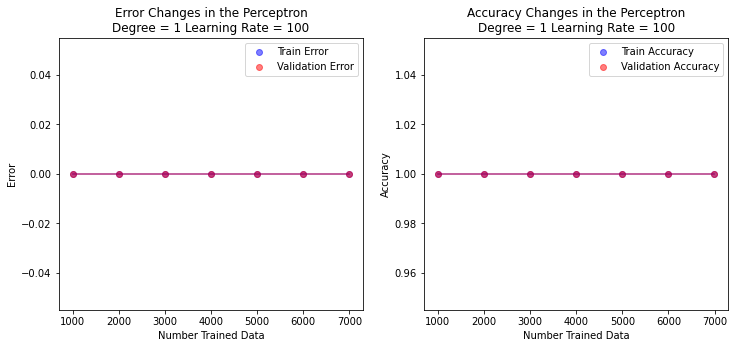

Final Train Accuracy = 1.0
Final Validation Accuracy = 1.0


In [13]:
for alpha in [1e-05, 0.01, 0.1, 1, 100]:
  print("====================================\n")
  print(f"alpha = {alpha}")
  perceptron = Perceptron(
                          alpha=alpha, degree = 1,
                          activation_function=ActivationFunctions.sign,
                          )

  perceptron.train(dataset = ls_dataset, epochs = 1)

  perceptron.show_decision_boundry()
  perceptron.show_error_values()

### Activation Function


t = -5


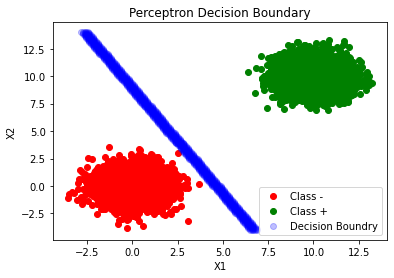

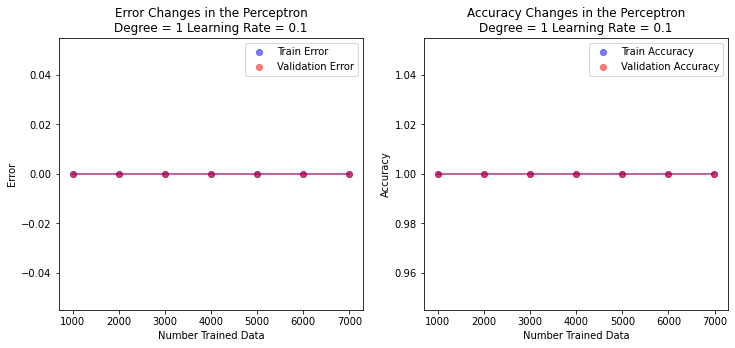

Final Train Accuracy = 1.0
Final Validation Accuracy = 1.0

t = 0


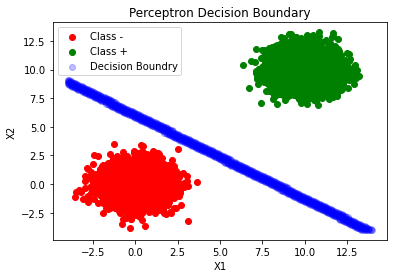

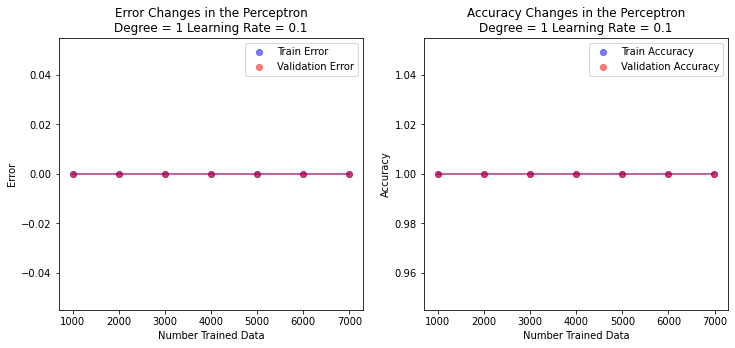

Final Train Accuracy = 1.0
Final Validation Accuracy = 1.0

t = 5


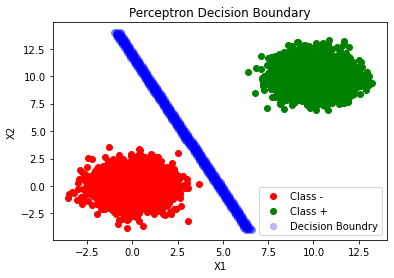

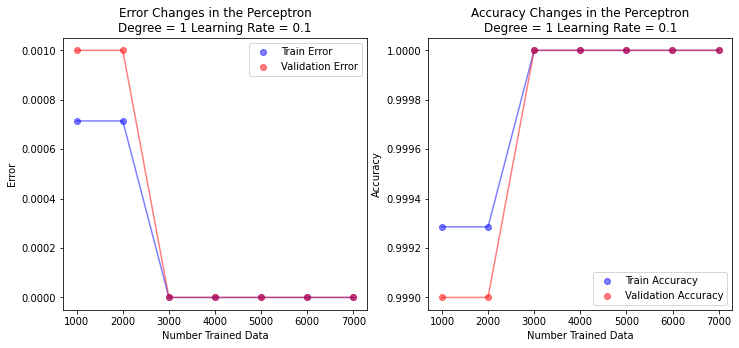

Final Train Accuracy = 1.0
Final Validation Accuracy = 1.0


In [14]:
for t in [-5, 0, +5]:
  print("====================================\n")
  print(f"t = {t}")
  perceptron = Perceptron(
                          alpha=0.1, degree = 1,
                          activation_function=ActivationFunctions.generate_step(t=t),
                          )

  perceptron.train(dataset = ls_dataset, epochs = 1)

  perceptron.show_decision_boundry()
  perceptron.show_error_values()

## Adaline

### Learning Rate


alpha = 1e-08


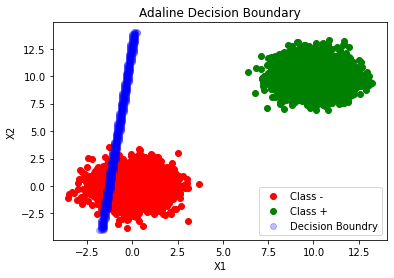

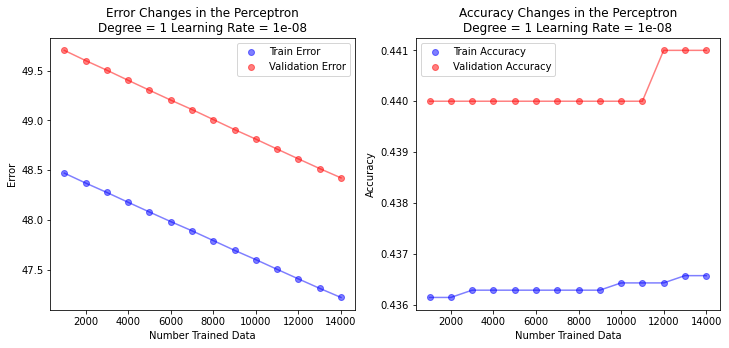

Final Train Accuracy = 0.43657142857142855
Final Validation Accuracy = 0.441

alpha = 1e-05


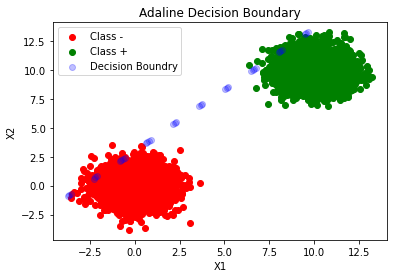

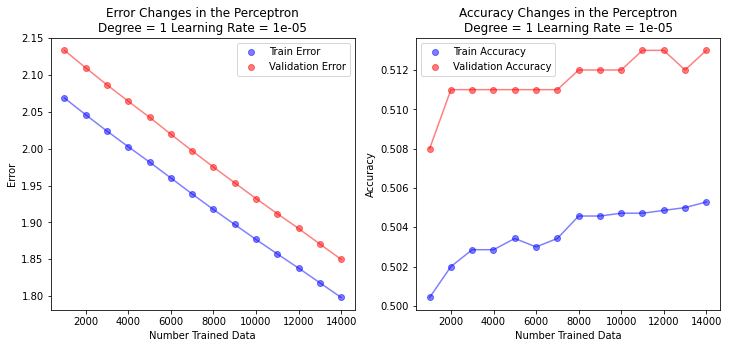

Final Train Accuracy = 0.5052857142857143
Final Validation Accuracy = 0.513

alpha = 0.0001


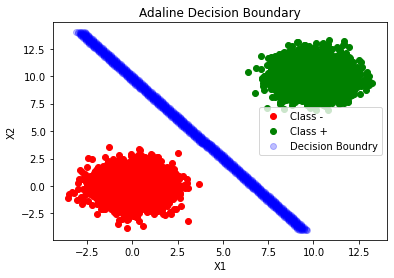

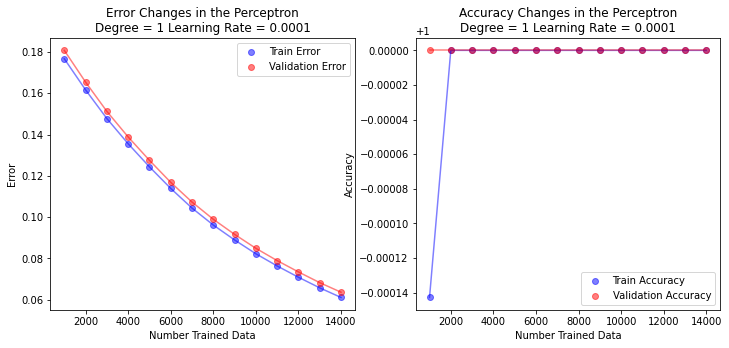

Final Train Accuracy = 1.0
Final Validation Accuracy = 1.0

alpha = 0.001


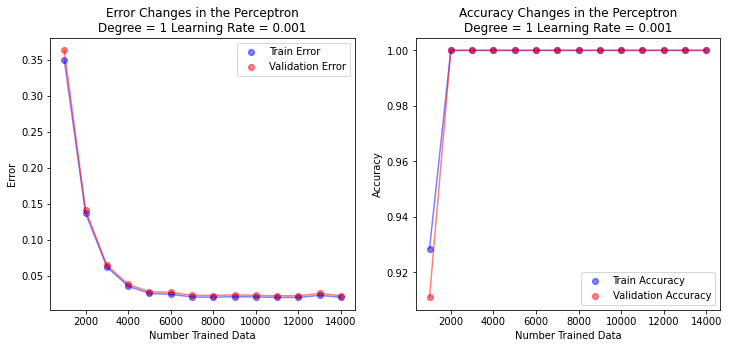

Final Train Accuracy = 1.0
Final Validation Accuracy = 1.0

alpha = 0.01


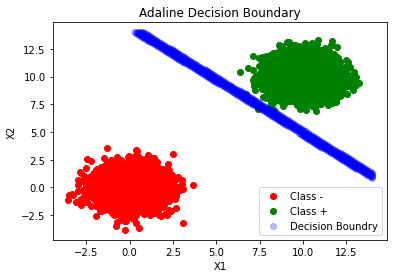

Final Train Accuracy = 0.9998571428571429
Final Validation Accuracy = 1.0


In [19]:
for alpha in [1e-08, 1e-05, 1e-04, 1e-03, 0.01]:
  print("====================================\n")
  print(f"alpha = {alpha}")
  adaline = Adaline(
                    alpha=alpha, degree = 1,
                    activation_function=ActivationFunctions.identity
                    )

  adaline.train(dataset = ls_dataset, epochs = 2)

  adaline.show_decision_boundry()
  adaline.show_error_values()

### Activation Function


Activation Function = Identity


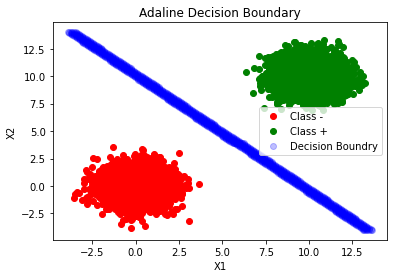

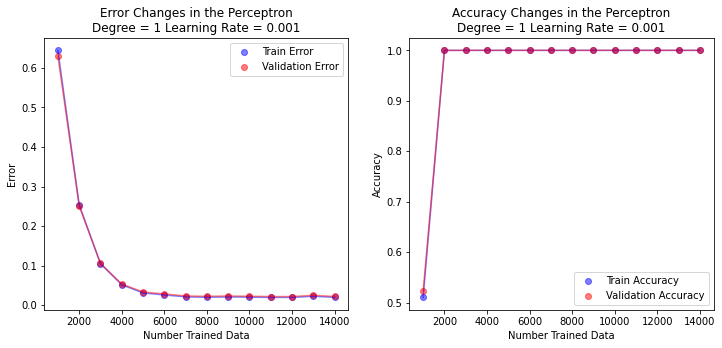

Final Train Accuracy = 1.0
Final Validation Accuracy = 1.0

Activation Function = Sigmoid


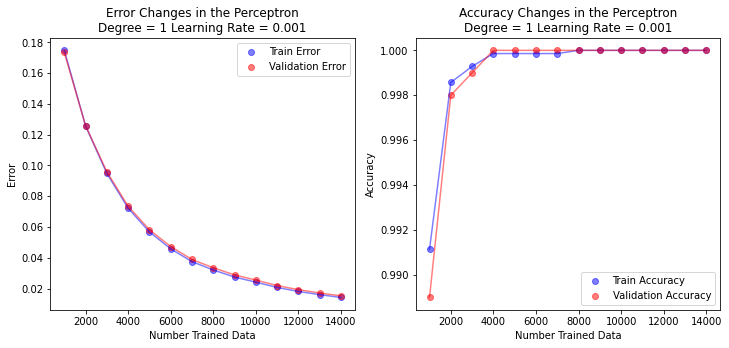

Final Train Accuracy = 1.0
Final Validation Accuracy = 1.0

Activation Function = Tanh


Final Train Accuracy = 1.0
Final Validation Accuracy = 1.0


In [20]:
for name, activation_function in zip(["Identity", "Sigmoid", "Tanh"]
                                     , [ActivationFunctions.identity,
                                        ActivationFunctions.bipolar_sigmoid,
                                        ActivationFunctions.tanh]):
  print("====================================\n")
  print(f"Activation Function = {name}")
  adaline = Adaline(
                    alpha=1e-03, degree = 1,
                    activation_function=activation_function
                    )

  adaline.train(dataset = ls_dataset, epochs = 2)

  adaline.show_decision_boundry()
  adaline.show_error_values()

# Expriments Part 5

## Perceptron

### Learning Rate


alpha = 1e-05


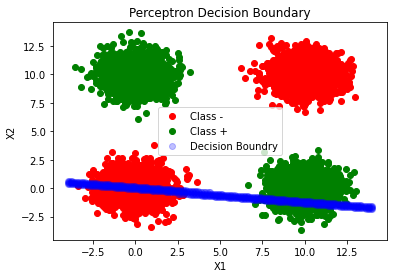

Final Train Accuracy = 0.6082857142857143
Final Validation Accuracy = 0.592

alpha = 0.01


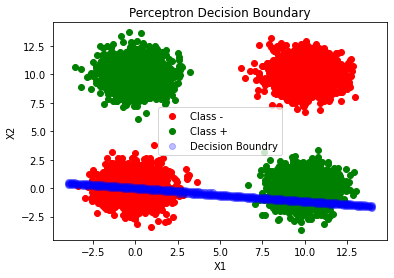

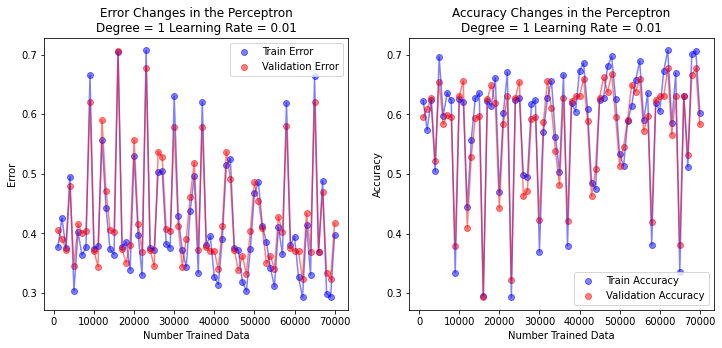

Final Train Accuracy = 0.602
Final Validation Accuracy = 0.583

alpha = 0.1


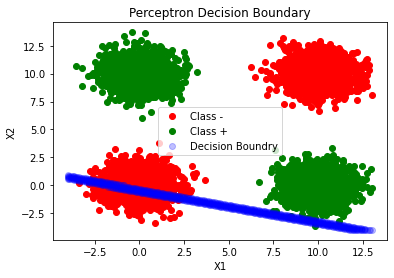

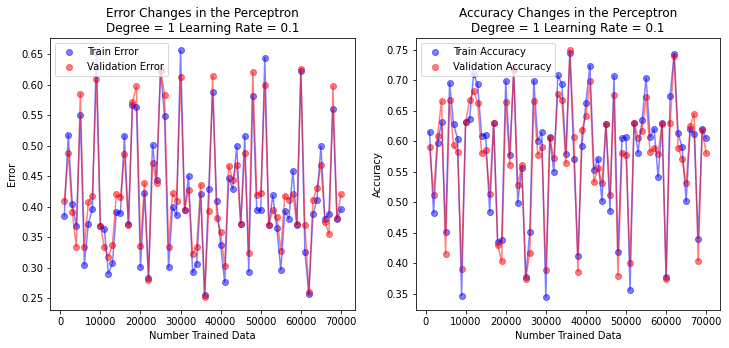

Final Train Accuracy = 0.6044285714285714
Final Validation Accuracy = 0.58

alpha = 1


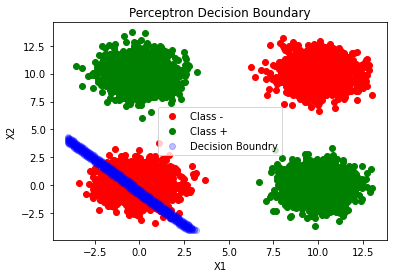

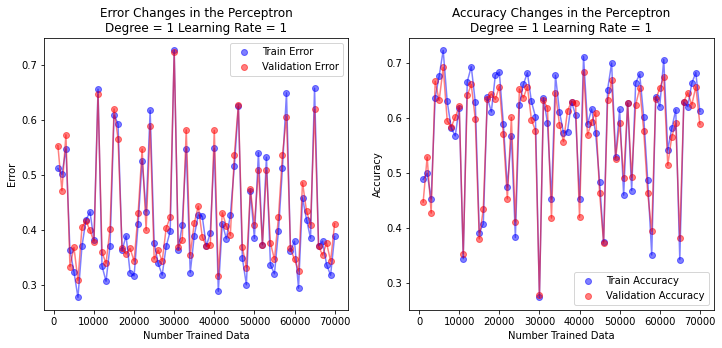

Final Train Accuracy = 0.6121428571428571
Final Validation Accuracy = 0.589

alpha = 100


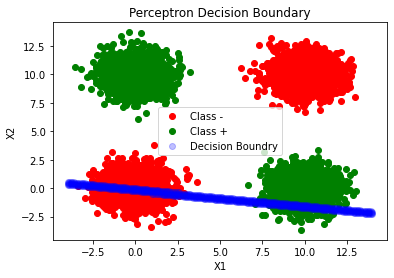

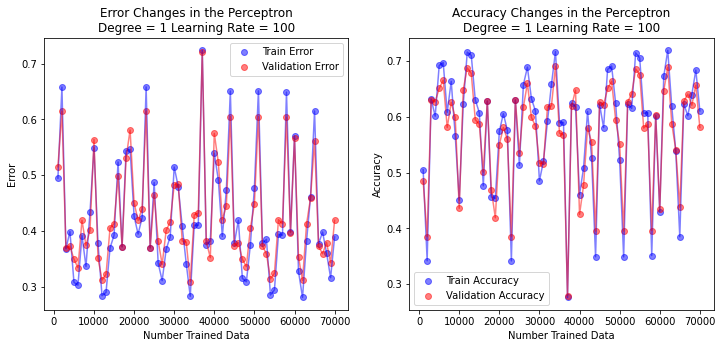

Final Train Accuracy = 0.6108571428571429
Final Validation Accuracy = 0.581


In [23]:
for alpha in [1e-05, 0.01, 0.1, 1, 100]:
  print("====================================\n")
  print(f"alpha = {alpha}")
  perceptron = Perceptron(
                          alpha=alpha, degree = 1,
                          activation_function=ActivationFunctions.sign,
                          )

  perceptron.train(dataset = xor_dataset, epochs = 10)

  perceptron.show_decision_boundry()
  perceptron.show_error_values()

### Activation Function


t = -5


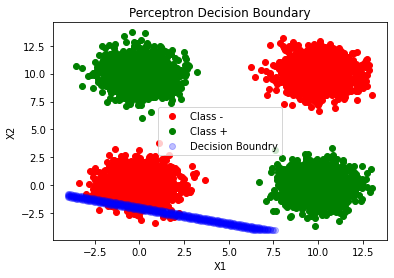

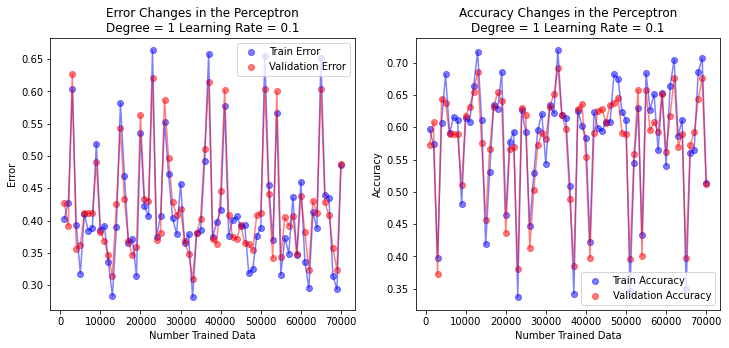

Final Train Accuracy = 0.5137142857142857
Final Validation Accuracy = 0.512

t = 0


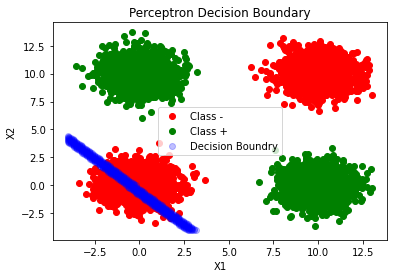

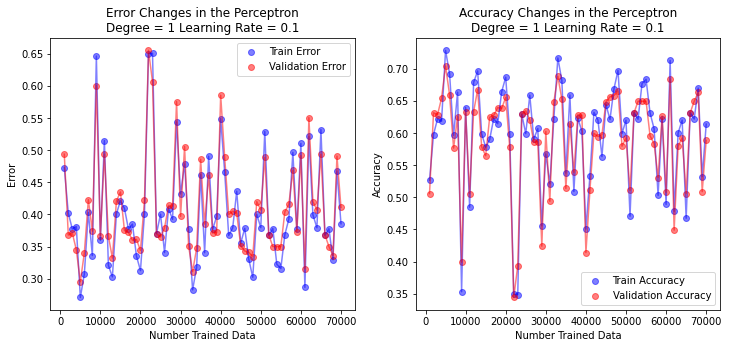

Final Train Accuracy = 0.6144285714285714
Final Validation Accuracy = 0.589

t = 5


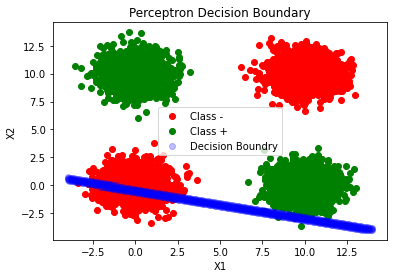

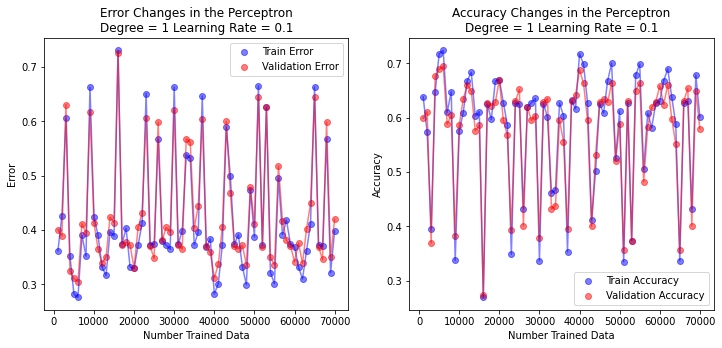

Final Train Accuracy = 0.6014285714285714
Final Validation Accuracy = 0.58


In [25]:
for t in [-5, 0, +5]:
  print("====================================\n")
  print(f"t = {t}")
  perceptron = Perceptron(
                          alpha=0.1, degree = 1,
                          activation_function=ActivationFunctions.generate_step(t=t),
                          )

  perceptron.train(dataset = xor_dataset, epochs = 10)

  perceptron.show_decision_boundry()
  perceptron.show_error_values()

## Adaline

### Learning Rate


alpha = 1e-08


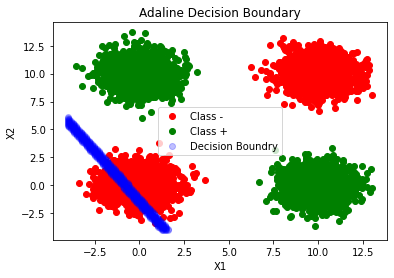

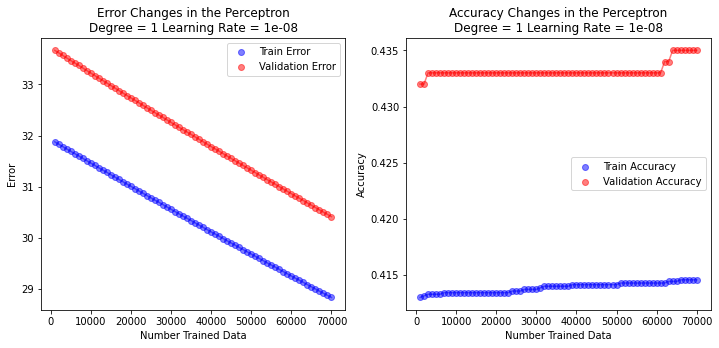

Final Train Accuracy = 0.4145714285714286
Final Validation Accuracy = 0.435

alpha = 1e-05


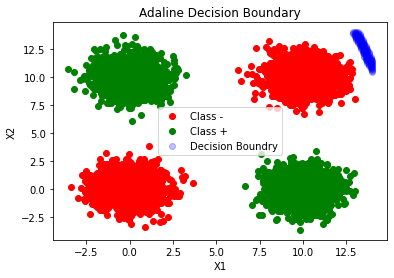

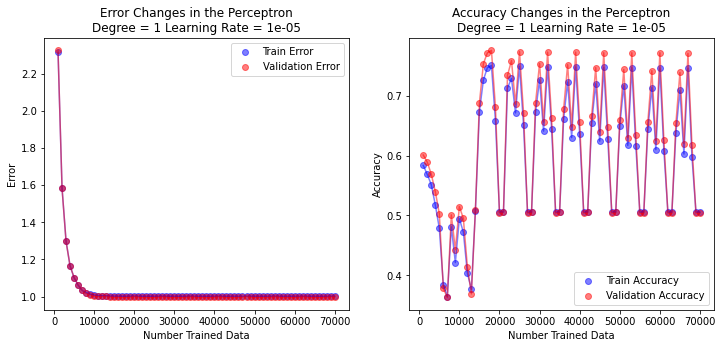

Final Train Accuracy = 0.5055714285714286
Final Validation Accuracy = 0.504

alpha = 0.0001


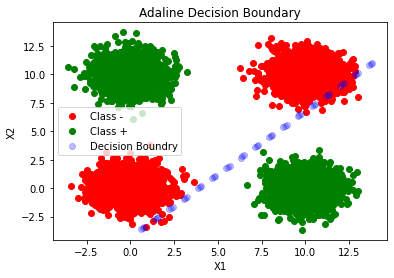

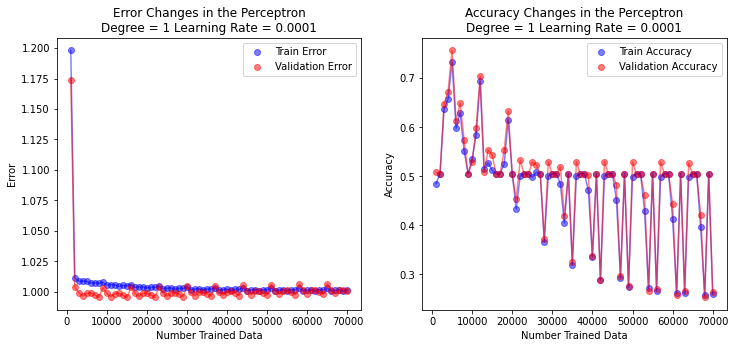

Final Train Accuracy = 0.26042857142857145
Final Validation Accuracy = 0.265

alpha = 0.001


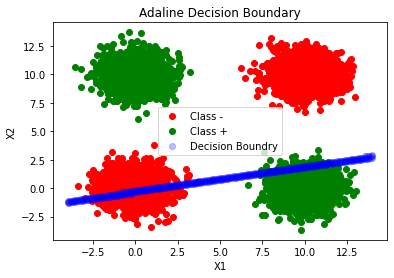

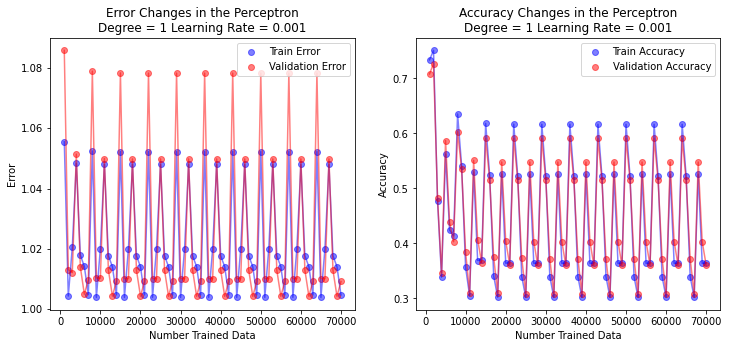

Final Train Accuracy = 0.36428571428571427
Final Validation Accuracy = 0.36

alpha = 0.01


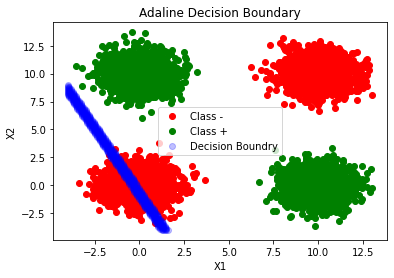

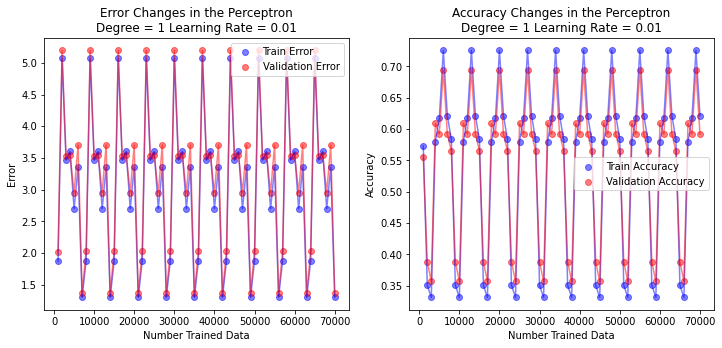

Final Train Accuracy = 0.6214285714285714
Final Validation Accuracy = 0.592


In [26]:
for alpha in [1e-08, 1e-05, 1e-04, 1e-03, 0.01]:
  print("====================================\n")
  print(f"alpha = {alpha}")
  adaline = Adaline(
                    alpha=alpha, degree = 1,
                    activation_function=ActivationFunctions.identity
                    )

  adaline.train(dataset = xor_dataset, epochs = 10)

  adaline.show_decision_boundry()
  adaline.show_error_values()

### Activation Function


Activation Function = Identity


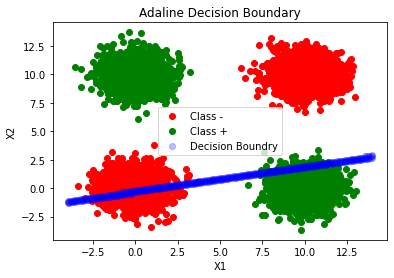

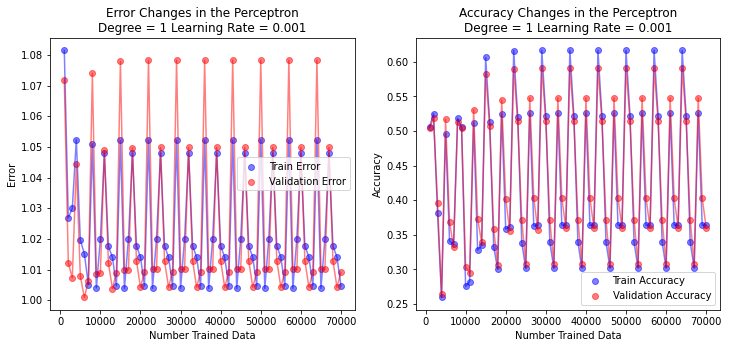

Final Train Accuracy = 0.36428571428571427
Final Validation Accuracy = 0.36

Activation Function = Sigmoid


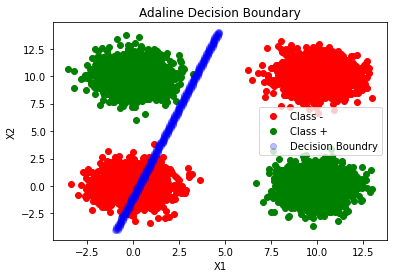

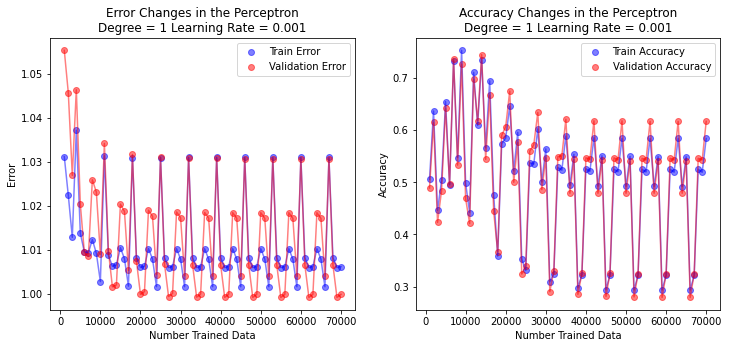

Final Train Accuracy = 0.5841428571428572
Final Validation Accuracy = 0.617

Activation Function = Tanh


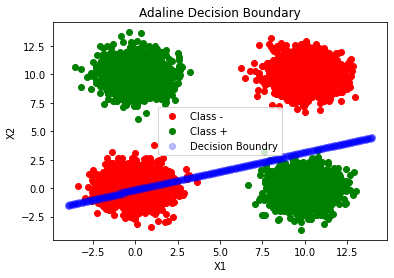

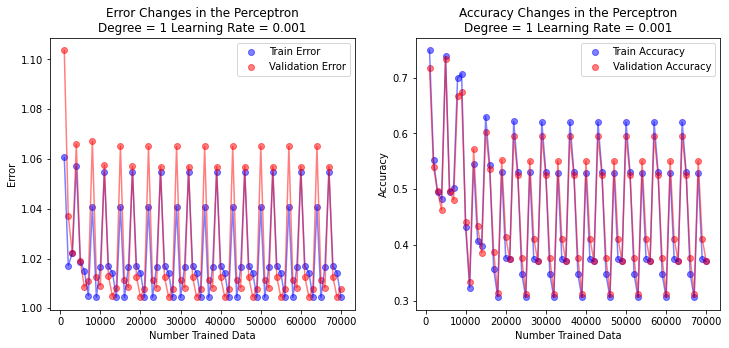

Final Train Accuracy = 0.37014285714285716
Final Validation Accuracy = 0.371


In [28]:
for name, activation_function in zip(["Identity", "Sigmoid", "Tanh"]
                                     , [ActivationFunctions.identity,
                                        ActivationFunctions.bipolar_sigmoid,
                                        ActivationFunctions.tanh]):
  print("====================================\n")
  print(f"Activation Function = {name}")
  adaline = Adaline(
                    alpha=1e-03, degree = 1,
                    activation_function=activation_function
                    )

  adaline.train(dataset = xor_dataset, epochs = 10)

  adaline.show_decision_boundry()
  adaline.show_error_values()

# Expriments Part 6

## Perceptron

### Learning Rate


alpha = 1e-05


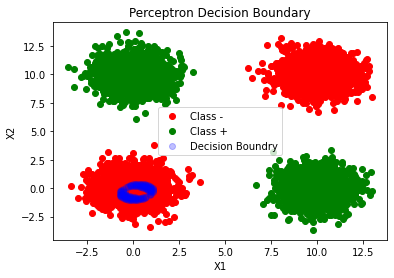

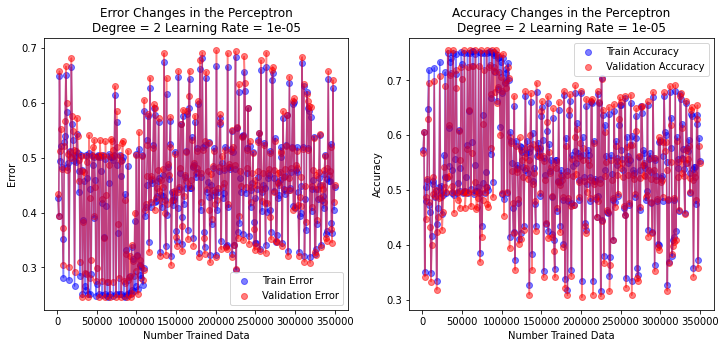

Final Train Accuracy = 0.5538571428571428
Final Validation Accuracy = 0.549

alpha = 0.01


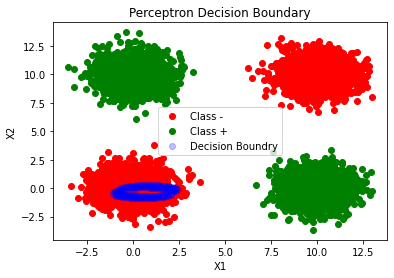

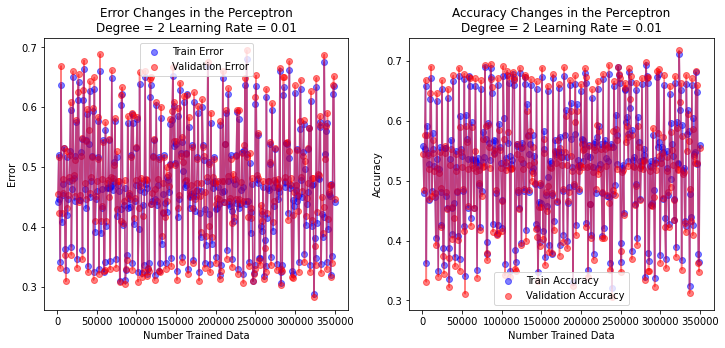

Final Train Accuracy = 0.559
Final Validation Accuracy = 0.554

alpha = 0.1


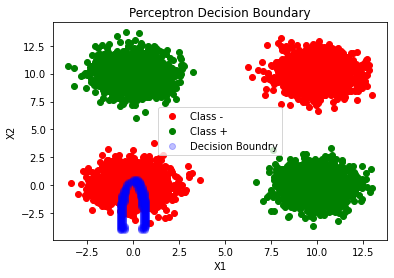

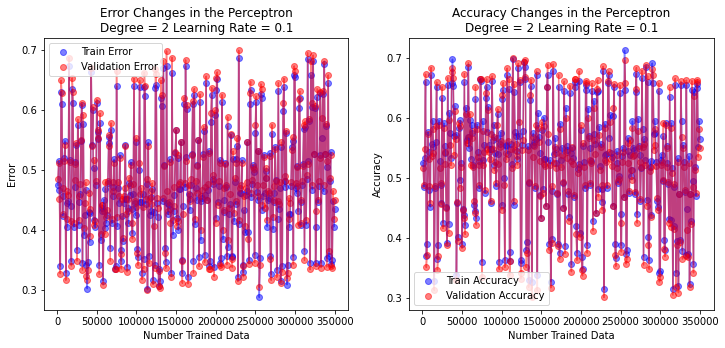

Final Train Accuracy = 0.565
Final Validation Accuracy = 0.55

alpha = 1


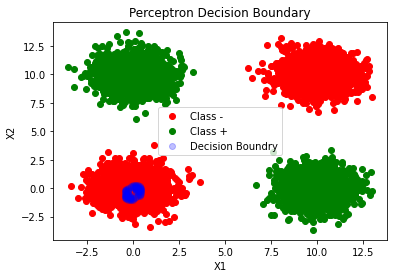

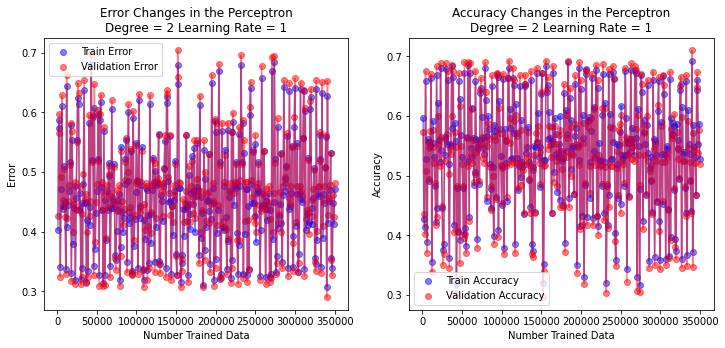

Final Train Accuracy = 0.5284285714285715
Final Validation Accuracy = 0.519

alpha = 100


Final Train Accuracy = 0.5518571428571428
Final Validation Accuracy = 0.546


In [30]:
for alpha in [1e-05, 0.01, 0.1, 1, 100]:
  print("====================================\n")
  print(f"alpha = {alpha}")
  perceptron = Perceptron(
                          alpha=alpha, degree = 2,
                          activation_function=ActivationFunctions.sign,
                          )

  perceptron.train(dataset = xor_dataset, epochs = 50)

  perceptron.show_decision_boundry()
  perceptron.show_error_values()

### Activation Function


t = -5


Final Train Accuracy = 0.5681428571428572
Final Validation Accuracy = 0.561

t = 0


Final Train Accuracy = 0.5265714285714286
Final Validation Accuracy = 0.516

t = 5


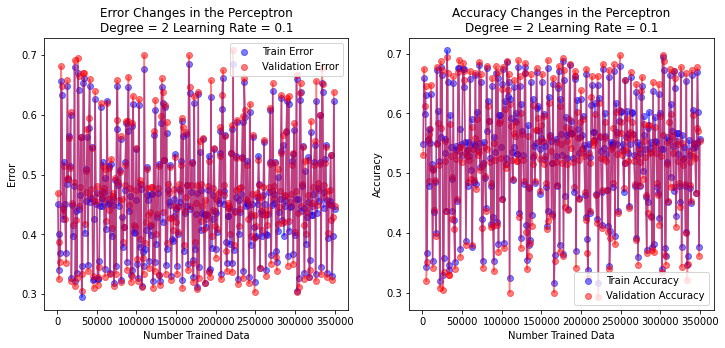

Final Train Accuracy = 0.5578571428571428
Final Validation Accuracy = 0.553


In [31]:
for t in [-5, 0, +5]:
  print("====================================\n")
  print(f"t = {t}")
  perceptron = Perceptron(
                          alpha=0.1, degree = 2,
                          activation_function=ActivationFunctions.generate_step(t=t),
                          )

  perceptron.train(dataset = xor_dataset, epochs = 50)

  perceptron.show_decision_boundry()
  perceptron.show_error_values()

## Adaline

### Learning Rate


alpha = 1e-09


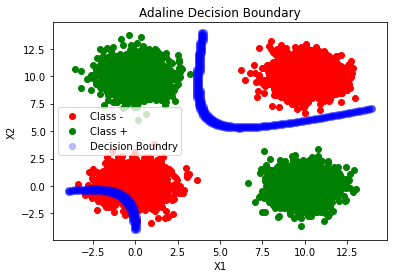

Final Train Accuracy = 0.22185714285714286
Final Validation Accuracy = 0.203

alpha = 1e-08


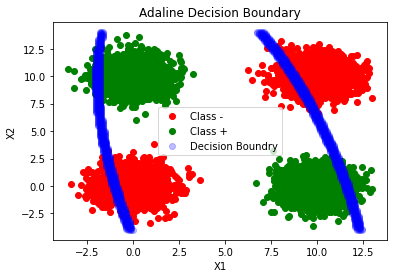

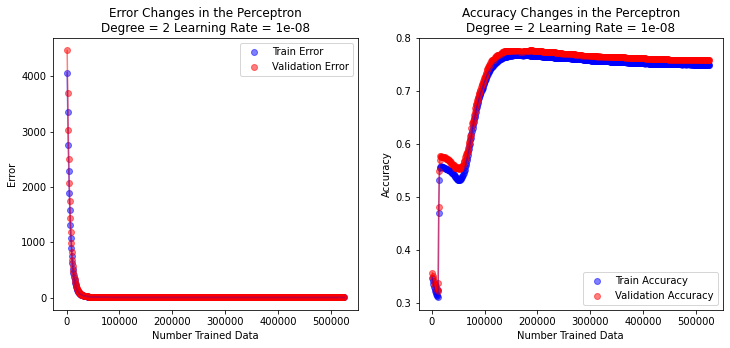

Final Train Accuracy = 0.7497142857142857
Final Validation Accuracy = 0.759

alpha = 1e-07


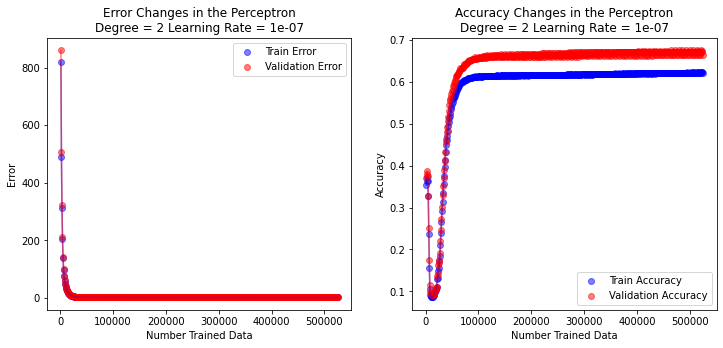

Final Train Accuracy = 0.6221428571428571
Final Validation Accuracy = 0.665

alpha = 1e-06


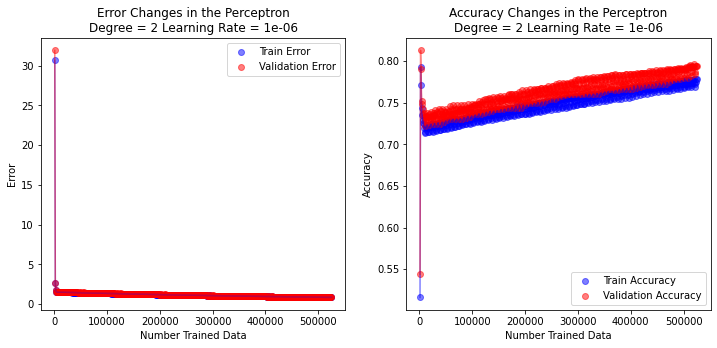

Final Train Accuracy = 0.778
Final Validation Accuracy = 0.794

alpha = 1e-05


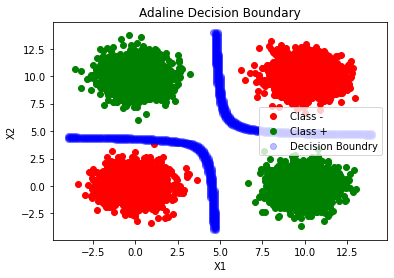

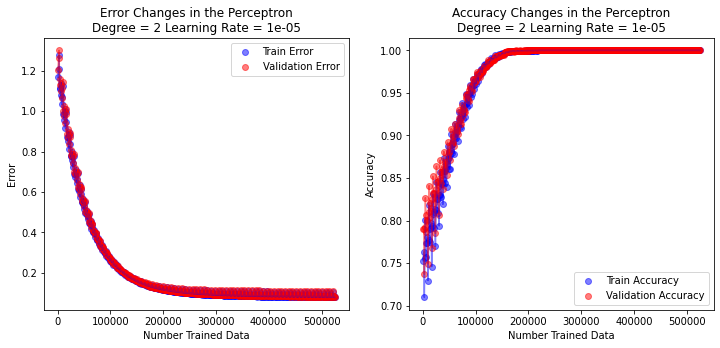

Final Train Accuracy = 1.0
Final Validation Accuracy = 1.0


In [34]:
for alpha in [1e-09, 1e-08, 1e-07, 1e-06, 1e-05]:
  print("====================================\n")
  print(f"alpha = {alpha}")
  adaline = Adaline(
                    alpha=alpha, degree = 2,
                    activation_function=ActivationFunctions.identity
                    )

  adaline.train( dataset = xor_dataset, epochs = 75)

  adaline.show_decision_boundry()
  adaline.show_error_values()

### Activation Function


Activation Function = Identity


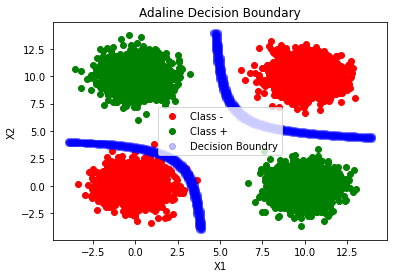

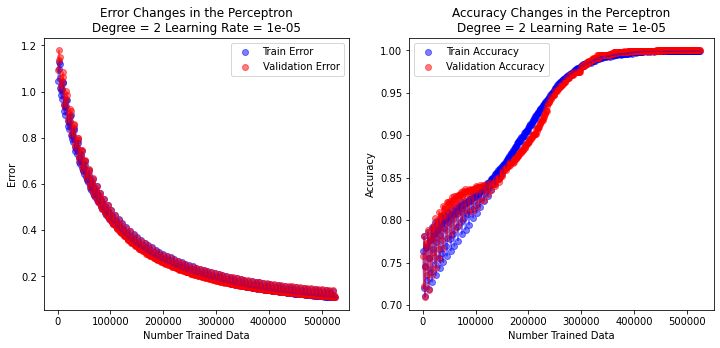

Final Train Accuracy = 0.9997142857142857
Final Validation Accuracy = 1.0

Activation Function = Sigmoid


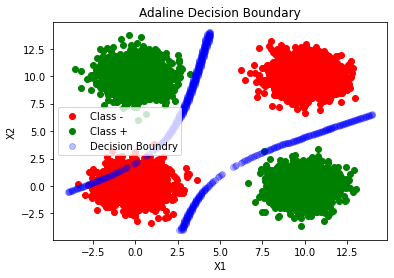

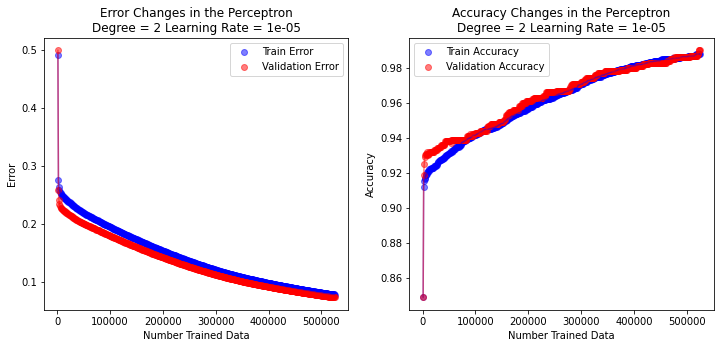

Final Train Accuracy = 0.9878571428571429
Final Validation Accuracy = 0.99

Activation Function = Tanh


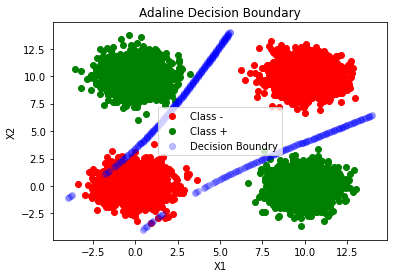

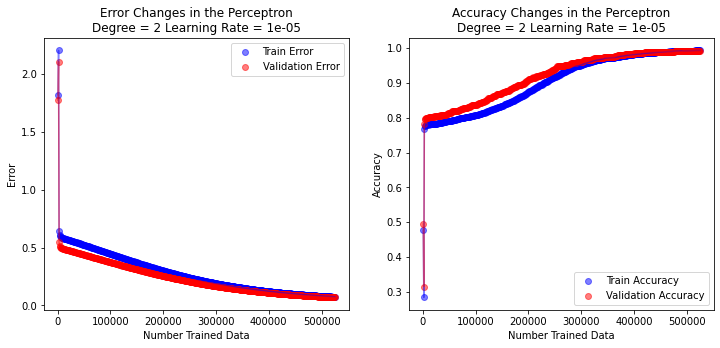

Final Train Accuracy = 0.9932857142857143
Final Validation Accuracy = 0.992


In [35]:
for name, activation_function in zip(["Identity", "Sigmoid", "Tanh"]
                                     , [ActivationFunctions.identity,
                                        ActivationFunctions.bipolar_sigmoid,
                                        ActivationFunctions.tanh]):
  print("====================================\n")
  print(f"Activation Function = {name}")
  adaline = Adaline(
                    alpha=1e-05, degree = 2,
                    activation_function=activation_function
                    )

  adaline.train(dataset = xor_dataset,epochs = 75)

  adaline.show_decision_boundry()
  adaline.show_error_values()